In [1]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df, convert_numeric_to_float16
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import itertools


In [2]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)

In [3]:

processed_data = convert_numeric_to_float16(processed_data)

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

`TODO:` divide them as FP and FN?

`TODO:` try SVM or ML models

`TODO:` At what point they were misclassified (e.g. at what point they diverge compared to the similar point with different prediction.) Look at the nearest neightbors with different neightbors. 

In [4]:
cv_analytics_utils = {}

In [5]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    ExperimentDataHelperSingleLabelScreenedFirst5,    
    ExperimentDataHelperScreenedFirst5,
    # ExperimentDataHelperNotScreenedColsFirst5,
    # ExperimentDataHelperScreenedColsFirst5,
    # ExperimentDataHelperScreenedOrCancer,
    # ExperimentDataHelperScreened,
    # ExperimentDataHelperNotScreenedCols,
    # ExperimentDataHelperScreenedCols,
    # ExperimentDataHelperAll,
    # ExperimentDataHelperSingleLabelScreenedOrCancer,
    # ExperimentDataHelperSingleLabelScreened,
    # ExperimentDataHelperSingleLabelNotScreenedCols,
    # ExperimentDataHelperSingleLabelScreenedCols,
    # ExperimentDataHelperSingleLabelAll,
    # ExperimentDataHelperScreenedFirst5ca125AndBinary,
    # ExperimentDataHelperScreenedFirst5ca125Binary, 
    # ExperimentDataHelperScreenedFirst5ca125AndBinaryNoResult,

]

In [6]:
# TODO: save propagated source df so that propagation does not have to happen all the time

In [7]:
years = [1]
num_folds=15
test_n_folds=15
train_size = 15000
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            label = f'cancer_in_next_{year}_years'
            filesuffix = f'experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_for_{label}_{num_folds}_trials'
            print(filesuffix)
            experiment_data_helper: ExperimentDataHelper = experiment_data_helper_class(processed_data, label, ['cancer_'], train_size = train_size)
            # experiment_data_helper.set_train_size_to_max(num_folds)
            experiment_runner = ExperimentRunner(classifier, experiment_data_helper, num_folds=num_folds, test_n_folds=test_n_folds)
            cv_analytics_util = experiment_runner.run_experiment()
            cv_analytics_utils[filesuffix] = cv_analytics_util
            cv_analytics_util.store_cv_analytics_utils(filesuffix)


experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials


[1.33822889e+01 1.02717694e+00 1.01112628e+00 2.50276933e+00
 2.71893539e-01 6.18943067e-02 1.71129651e+00 8.33619893e-01
 1.42632120e-01 4.73873386e-01 1.53147567e-02 1.55483138e+01
 8.09801092e-02 5.97950267e-01 1.72708266e+00 1.71055895e+00
 1.47321847e+00 2.02458157e+00 1.08844326e+00 7.83879591e-01
 3.23185091e+00 2.81078840e+00 1.39040971e+00 1.70479146e+00
 1.54292497e+00 5.48944252e-01 2.98319328e+00 1.83644983e-02
 4.62198484e-01 4.14575935e-01 1.96242526e+01 1.22281899e+01
 5.72804795e-02 5.69871766e-02 5.52069052e-02 3.23334884e+00
 1.00643800e+01 1.79746233e-02 1.58708246e-01 4.14954364e-01
 1.76198647e+00 8.12058946e-03 2.22550045e+00 9.28299419e-01
 5.82472350e+01 4.03587329e-01 2.86189565e+00 1.44322448e-01
 1.15884515e+01 4.44726933e-01 1.01197480e+00 2.40436348e-01
 6.27659838e+01 1.76706993e+00 1.48317973e+00 1.53206821e+00
 3.18113984e-01 1.26545915e+00 4.23453398e-02 1.83040787e+00
 1.26748359e+01 5.08255036e-02 2.21107627e-01 1.97161016e+00
 8.79696281e+02 1.583758

In [21]:
analytics_util_0 = cv_analytics_utils['experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials'].analytics_utils[0]

In [28]:
df_0 = analytics_util_0.data_util.test_df

In [10]:
processed_data['ca125ii_level_binary'] = 0

In [11]:
transformed_df = analytics_util_0.data_util.imputer.imputer_transform(processed_data)

In [12]:
transformed_df[transformed_df['index'] == 228522]

,ovar_cancer,ovar_behavior,ovar_histtype,plco_id,ca125ii_level,ovary_trial_flag,educat,marital,occupat,pipe,...,volum,cancer_in_next_1_years,cancer_in_next_3_years,cancer_in_next_5_years,cancer_in_next_10_years,ovar_observe_year,was_screened,ph_any_not_ovar_bq,index,ca125ii_level_binary
228522,0.0,2.983193,-1,A-077228-7,9.0,1.0,7.0,1.0,1.0,0.0,...,10.06438,0.0,0.0,0.0,0.0,5.0,1.0,0,228522.0,0.0


In [13]:
processed_data[processed_data['index'] == 228522]

,ovar_cancer,ovar_behavior,ovar_histtype,plco_id,ca125ii_level,ovary_trial_flag,educat,marital,occupat,pipe,...,volum,cancer_in_next_1_years,cancer_in_next_3_years,cancer_in_next_5_years,cancer_in_next_10_years,ovar_observe_year,was_screened,ph_any_not_ovar_bq,index,ca125ii_level_binary
228522,0.0,NaN,NaN,A-077228-7,9.0,1.0,7.0,1.0,1.0,0.0,...,NaN,0.0,0.0,0.0,0.0,5.0,1.0,0.0,228522,0


In [29]:
df_0[df_0['index'] == 228522]

,plco_id,age,agelevel,arthrit_f,asp,asppd,bbd,bcontr_f,bcontra,bcontrt,...,uterine_fib,visboth,viseith,visl,visr,volum,was_screened,weight20_f,weight50_f,weight_f
3732,A-077228-7,70.0,2.0,0.0,1.0,1.0,0.0,1.0,2.0,5.0,...,1.0,0,0,0,0,10.06438,1.0,127.0,118.0,125.0


In [15]:
cv_analytics_utils['experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials'].analytics_utils[0].data_util.imputer.imputer_mean.statistics_

array([1.33822889e+01, 1.02717694e+00, 1.01112628e+00, 2.50276933e+00,
       2.71893539e-01, 6.18943067e-02, 1.71129651e+00, 8.33619893e-01,
       1.42632120e-01, 4.73873386e-01, 1.53147567e-02, 1.55483138e+01,
       8.09801092e-02, 5.97950267e-01, 1.72708266e+00, 1.71055895e+00,
       1.47321847e+00, 2.02458157e+00, 1.08844326e+00, 7.83879591e-01,
       3.23185091e+00, 2.81078840e+00, 1.39040971e+00, 1.70479146e+00,
       1.54292497e+00, 5.48944252e-01, 2.98319328e+00, 1.83644983e-02,
       4.62198484e-01, 4.14575935e-01, 1.96242526e+01, 1.22281899e+01,
       5.72804795e-02, 5.69871766e-02, 5.52069052e-02, 3.23334884e+00,
       1.00643800e+01, 1.79746233e-02, 1.58708246e-01, 4.14954364e-01,
       1.76198647e+00, 8.12058946e-03, 2.22550045e+00, 9.28299419e-01,
       5.82472350e+01, 4.03587329e-01, 2.86189565e+00, 1.44322448e-01,
       1.15884515e+01, 4.44726933e-01, 1.01197480e+00, 2.40436348e-01,
       6.27659838e+01, 1.76706993e+00, 1.48317973e+00, 1.53206821e+00,
      

In [16]:
# cv_analytics_util.set_filter(differentiate_confusion_matrix_over['was_screened'][0][1])

In [17]:
for analytics_util in cv_analytics_util.analytics_utils: 
    print(analytics_util.get_report_generation_util().get_roc_threshold())

0.007688015233725309
0.6705222725868225
0.008672320283949375
0.3227933347225189
0.04857155308127403
0.01108928769826889
0.042443402111530304
0.013526096008718014
0.1263727992773056
0.04287675768136978
0.6379655003547668
0.20466509461402893
0.3305627405643463
0.004938589874655008
0.005395017098635435


In [18]:
# for key, cv_analytics_util in cv_analytics_utils.items():
#     print(f"{key}: ")
#     filepath = f'./trees/decision_tree_for_{key}.png'
#     cv_analytics_util.analytics_utils[0].plot_save_tree(False, filepath)

In [19]:
# TODO: test the model with single lable with the same test set

experiment_participants_screened_single_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials: 


Cross-Validation measures:
+--------------------+----------+-------------+-----------+----------+
|                    |     mean |         std |       min |      max |
|--------------------+----------+-------------+-----------+----------|
| precision__class_0 | 0.999672 | 0.000160794 | 0.999459  | 1        |
| recall__class_0    | 0.996726 | 0.00101152  | 0.994262  | 0.99804  |
| f1-score__class_0  | 0.998197 | 0.000532475 | 0.996854  | 0.998883 |
| precision__class_1 | 0.123492 | 0.050883    | 0.0447761 | 0.225806 |
| recall__class_1    | 0.573148 | 0.20843     | 0.25      | 1        |
| f1-score__class_1  | 0.20173  | 0.079443    | 0.0789474 | 0.358974 |
| accuracy           | 0.996402 | 0.00106027  | 0.993729  | 0.997771 |
| auc                | 0.945344 | 0.0346453   | 0.884864  | 0.999444 |
+--------------------+----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


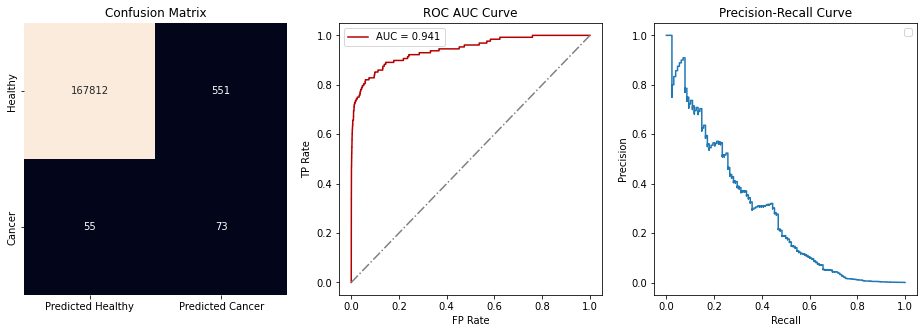

experiment_participants_screened_first_5_XGBClassifier_for_cancer_in_next_1_years_15_trials: 


Cross-Validation measures:
+--------------------+-----------+-------------+----------+----------+
|                    |      mean |         std |      min |      max |
|--------------------+-----------+-------------+----------+----------|
| precision__class_0 | 0.999538  | 0.000243828 | 0.998926 | 0.999823 |
| recall__class_0    | 0.996613  | 0.00113077  | 0.994743 | 0.998937 |
| f1-score__class_0  | 0.998073  | 0.000593058 | 0.99683  | 0.99907  |
| precision__class_1 | 0.0906348 | 0.0760542   | 0        | 0.294118 |
| recall__class_1    | 0.387245  | 0.227804    | 0        | 0.777778 |
| f1-score__class_1  | 0.138941  | 0.096058    | 0        | 0.322581 |
| accuracy           | 0.996156  | 0.00118117  | 0.993681 | 0.998142 |
| auc                | 0.833886  | 0.106065    | 0.635356 | 0.975218 |
+--------------------+-----------+-------------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


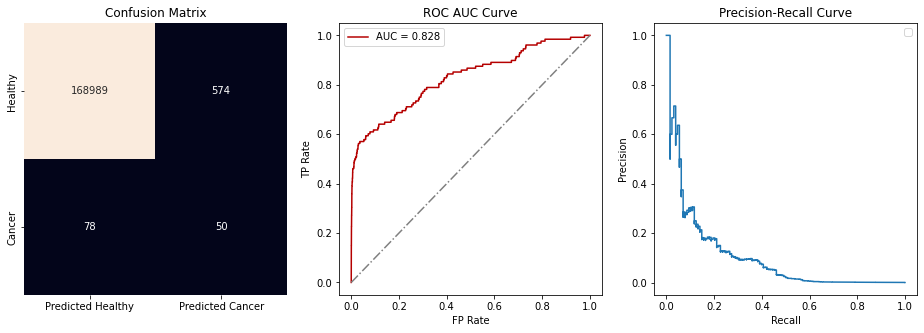

In [20]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    cv_analytics_util.update_thresholds(None)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()